# Проект Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Антивирус `DeviceProtection`
- Блокировка небезопасных сайтов `OnlineSecurity`
- Выделенная линия технической поддержки `TechSupport`
- Облачное хранилище файлов `OnlineBackup`
- Стриминговое телевидение `StreamingTV`
- Каталог фильмов `StreamingMovies`

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` - информация о договоре
- `personal_new.csv` - персональные данные клиента
- `internet_new.csv` - информация об интернет-услугах
- `phone_new.csv`- информация об услугах телефонии

Файл `contract_new.csv`

- `customerID` - идентификатор абонента
- `BeginDate` - дата начала действия договора
- `EndDate` - дата окончания действия договора
- `Type` - тип оплаты: раз в год-два или ежемесячно
- `PaperlessBilling` - электронный расчётный лист
- `PaymentMethod` - тип платежа
- `MonthlyCharges` - расходы за месяц
- `TotalCharges` - общие расходы абонента

Файл `personal_new.csv`

- `customerID` - идентификатор пользователя
- `gender` - пол
- `SeniorCitizen` - является ли абонент пенсионером
- `Partner` - есть ли у абонента супруг или супруга
- `Dependents` - есть ли у абонента дети

Файл `internet_new.csv`

- `customerID` - идентификатор пользователя
- `InternetService` - тип подключения
- `OnlineSecurity` - блокировка опасных сайтов
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
- `DeviceProtection` - антивирус
- `TechSupport` - выделенная линия технической поддержки
- `StreamingTV` - стриминговое телевидение
- `StreamingMovies` - каталог фильмов

Файл `phone_new.csv`

- `customerID` - идентификатор пользователя
- `MultipleLines` - подключение телефона к нескольким линиям одновременно

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## План работы

1. Анализ и просмотр исходных данных.
2. Предобработка данных (Очистка, добавление признаков).
3. Исследовательский анализ.
4. Корреляционный анализ.
5. Построение модели машинного обучения.
6. Оценка важности признаков.
7. Оценка качество предсказаний.
8. Вывод

## Цель проекта

Построить модель машинного обучения, прогнозирующая уход клиента.

# Настройки

## Модули

In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import shap

from scipy.stats import norm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Подключение

In [2]:
directory = Path().resolve()
directory_file = directory.parent / ".source" / "TeleHome"

try:
    contract = pd.read_csv(directory_file / 'contract_new.csv', parse_dates=['BeginDate'])
    internet = pd.read_csv(directory_file / 'internet_new.csv')
    personal = pd.read_csv(directory_file / 'personal_new.csv')
    phone = pd.read_csv(directory_file / 'phone_new.csv')
except FileNotFoundError:
    contract = pd.read_csv(r'/datasets/contract_new.csv', parse_dates=['BeginDate'])
    internet = pd.read_csv(r'/datasets/internet_new.csv')
    personal = pd.read_csv(r'/datasets/personal_new.csv')
    phone = pd.read_csv(r'/datasets/phone_new.csv')

## Пользовательские функции

In [3]:
def get_data_info(dataframe: pd.DataFrame) -> None:
    """Функция для получения общих сведений о данных."""

    display(dataframe.head(10))
    print('-' * 25)
    display(dataframe.info())
    print('-' * 25)
    print(f'Количество явных дубликатов: {dataframe.duplicated().sum()}')
    print(f'Количество дубликатов идентификатора: {dataframe.duplicated(subset=dataframe.columns[0]).sum()}')

In [4]:
def get_graph_plot(dataframe: pd.DataFrame, column: str, label: str, xlabel: str):
    """Функция построения гистограммы и диаграммы размаха для непрерывных признаков."""

    # Расчёт среднего и стандартного отклонения для нормального распределения.
    mean = np.mean(dataframe[column])
    std = np.std(dataframe[column])

    # Создание сетки значений по оси `x`.
    x = np.linspace(dataframe[column].min(), dataframe[column].max(), 200)
    y = norm.pdf(x, mean, std) * len(dataframe[column]) * (dataframe[column].max() - dataframe[column].min()) / 40

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    plt.subplots_adjust(right=0.5)

    sns.histplot(dataframe[column], ax=axs[0], bins=40, kde=True, color='orange', shrink=0.8)
    axs[0].axvline(dataframe[column].mean(), color='red', linestyle='-', label='Среднее')
    axs[0].axvline(dataframe[column].median(), color='blue', linestyle='-', label='Медиана')
    axs[0].plot(x, y, color='green', label='Нормальное распределение')

    axs[0].set_title(f'Гистограмма')
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel('Количество')
    axs[0].legend(fontsize=10)

    sns.boxplot(x=dataframe[column], ax=axs[1], color='skyblue')
    axs[1].set_title(f'Диаграмма размаха')
    axs[1].set_xlabel(xlabel)

    fig.suptitle(label)
    plt.tight_layout()
    plt.show()

In [5]:
def get_graph_pie(df: pd.DataFrame, column: str, churn_col: str = 'activity'):
    """Построение сравнительного barplot для признака."""

    percent_df = (df.groupby(churn_col)[column].value_counts(normalize=True).rename("percentage").reset_index())

    plt.figure(figsize=(15, 5))
    sns.barplot(data=percent_df, x=column, y="percentage", hue=churn_col, palette="pastel")

    plt.title(f'Распределение признака "{column}" по группам оттока', fontsize=16, fontweight='bold')
    plt.ylabel('Доля клиентов (%)')
    plt.xlabel(column)
    plt.xticks(rotation=0)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.tight_layout()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, labels=None, title="Матрица ошибок"):
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1.2)

    ax = sns.heatmap(cm,
                     annot=True,
                     fmt='d',
                     cmap='Blues',
                     linewidths=0.5,
                     linecolor='gray',
                     cbar=True,
                     xticklabels=labels,
                     yticklabels=labels,
                     annot_kws={"size": 14})

    plt.title(title, fontsize=16, pad=15)
    plt.xlabel('Предсказанные классы', fontsize=13)
    plt.ylabel('Истинные классы', fontsize=13)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 1. Анализ и просмотр данных

In [7]:
get_data_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

-------------------------
Количество явных дубликатов: 0
Количество дубликатов идентификатора: 0


In [8]:
get_data_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

-------------------------
Количество явных дубликатов: 0
Количество дубликатов идентификатора: 0


In [9]:
get_data_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

-------------------------
Количество явных дубликатов: 0
Количество дубликатов идентификатора: 0


In [10]:
get_data_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

-------------------------
Количество явных дубликатов: 0
Количество дубликатов идентификатора: 0


## Промежуточный вывод

При первичном рассмотрении предоставленных данных критических ошибок не замечено.

- Пропущенные значения во всех датасетах отсутствуют.
- Явные дубликаты отсутствуют.
- Дубликаты по идентификатору `customerID` отсутствуют.

# 2. Предобработка данных

## 2.1 Объединение данных

In [11]:
df_union = contract.merge(personal, 
                          on='customerID', 
                          how='outer').merge(internet, 
                                             on='customerID', 
                                             how='outer').merge(phone, 
                                                                on='customerID', 
                                                                how='outer')

## 2.2 Переименование столбцов

In [12]:
correct_names = []

for name in df_union.columns:
    correct_name = re.sub(r'(?<!^)([A-Z])', r'_\1', name).lower()
    correct_name = re.sub(r'_i_d$', '_id', correct_name)
    correct_name = re.sub(r'_t_v$', '_tv', correct_name)
    correct_names.append(correct_name)

df_union.columns = correct_names

In [13]:
get_data_info(df_union)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.60,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,539.1,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.90,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.00,1372.0,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.90,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No
5,0013-MHZWF,2019-05-01,No,Month-to-month,Yes,Credit card (automatic),69.40,655.83,Female,0,No,Yes,DSL,No,No,No,Yes,Yes,Yes,No
6,0013-SMEOE,2014-03-01,No,Two year,Yes,Bank transfer (automatic),109.70,7866.59,Female,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
7,0014-BMAQU,2014-11-01,No,Two year,Yes,Credit card (automatic),84.65,5332.95,Male,0,Yes,No,Fiber optic,Yes,No,No,Yes,No,No,Yes
8,0015-UOCOJ,2019-07-01,No,Month-to-month,Yes,Electronic check,48.20,337.4,Female,1,No,No,DSL,Yes,No,No,No,No,No,No
9,0016-QLJIS,2014-09-01,No,Two year,Yes,Mailed check,90.45,5879.25,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   ob

None

-------------------------
Количество явных дубликатов: 0
Количество дубликатов идентификатора: 0


Все данные были объединены по идентификатору `customerID` в общий датафрейм `df_union`, а название столбцов приведены к общепринятому регистру.

В результате обработки в столбцах дополнительных услуг `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines` образовались пропуски. Удалить полученные строки будет неправильно, так как клиенты могли просто не пользоваться ими, поэтому заполним пропущенные значения `No`.

## 2.3 Заполнение пропусков

In [14]:
not_marked = ['internet_service',
              'online_security',
              'online_backup',
              'device_protection',
              'tech_support',
              'streaming_tv',
              'streaming_movies',
              'multiple_lines']

df_union[not_marked] = df_union[not_marked].fillna('No')

In [15]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

## 2.4 Добавление признаков

In [16]:
df_union['activity'] = 1
df_union.loc[df_union['end_date'] == 'No', 'activity'] = 0

In [17]:
df_union['end_date'] = df_union['end_date'].replace('No', '2020-02-01')
df_union['end_date'] = pd.to_datetime(df_union['end_date'])
df_union['duration_contract'] = (df_union['end_date'] - df_union['begin_date']).dt.days

## 2.5 Преобразование признаков

In [18]:
df_union[df_union['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,activity,duration_contract
945,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0
1731,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,No,No,No,No,No,No,No,No,0,0
1906,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,,Male,0,...,DSL,Yes,Yes,No,Yes,No,No,Yes,0,0
2025,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,No,No,No,No,No,No,No,No,0,0
2176,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,No,No,No,No,No,No,No,No,0,0
2250,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
2855,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0
3052,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
3118,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
4054,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0


In [19]:
df_union.loc[df_union['total_charges'] == ' ', 'total_charges'] = 0
df_union['total_charges'] = df_union['total_charges'].astype(float)

## Промежуточный вывод

В рамках этапа предобработки данных был создан единый датафрейм `df_union` включающий в себя все ранее представленные данные.

Объединённый датафрейм стал содержать пропуски из данных дополнительных услуг, возникшие предположительно в силу не использования клиентами последних. Все такие строки были промаркированы `Not Marked` для возможности последующей фильтрации если такое будет необходимо.

Так же приведён к корректному типу признак `total_charges` с `object` на `float64`.  В процессе приведения выявлены пустые строки, связанные с тем, что дата заключения договора совпадает с датой выгрузки и нет информации о суммарных тратах. Такие данные заполнены `0`.

Для дальнейшего исследования были созданы дополнительные признаки.

1. `activity` - Отказался ли клиент от услуг или нет.
2. `duration_contract` - Признак указывает на продолжительность контракта. Датой отсечки была взята дата актуальной выгрузки 2020-02-01.

# 3. Исследовательский анализ

## 3.1 Признак `total_charges`

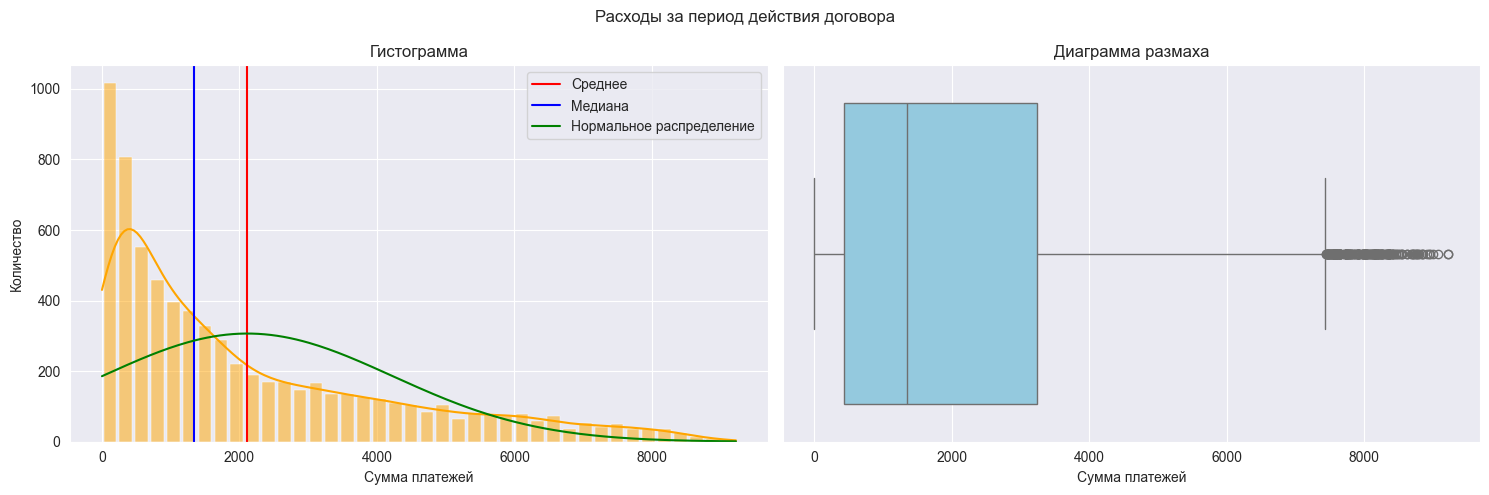

In [20]:
get_graph_plot(df_union, 'total_charges', 'Расходы за период действия договора', 'Сумма платежей')

In [21]:
df_union['total_charges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

Суммарная сумма расходов половины клиентов укладывается в 1343 за все время обслуживания, при этом 75% клиентов потратили не более 3200.

## 3.1 Признак `monthly_charges`

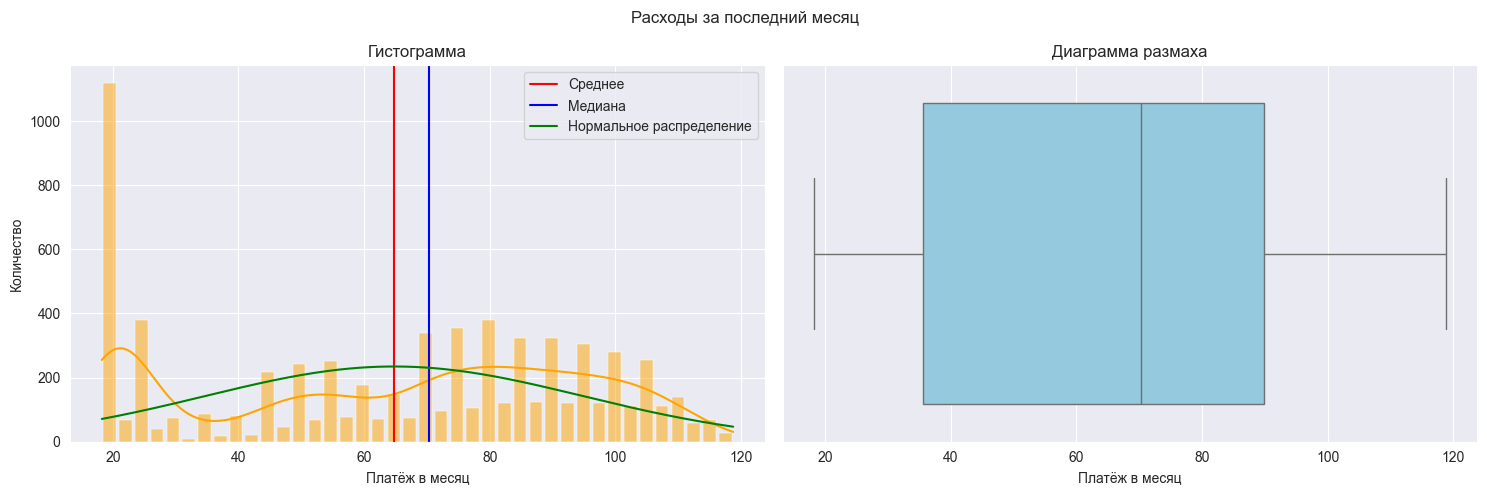

In [22]:
get_graph_plot(df_union, 'monthly_charges', 'Расходы за последний месяц', 'Платёж в месяц')

In [23]:
df_union['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

Наблюдается явный выброс на значении месячного платежа 20, это может быть связано как с тем что клиенты пользуются минимальным пакетом услуг, так и наличием акционный стоимости услуг при недавнем подключении. Значение среднего и медианного достаточно близки друг к другу.

## 3.3 Признак `duration_contract`

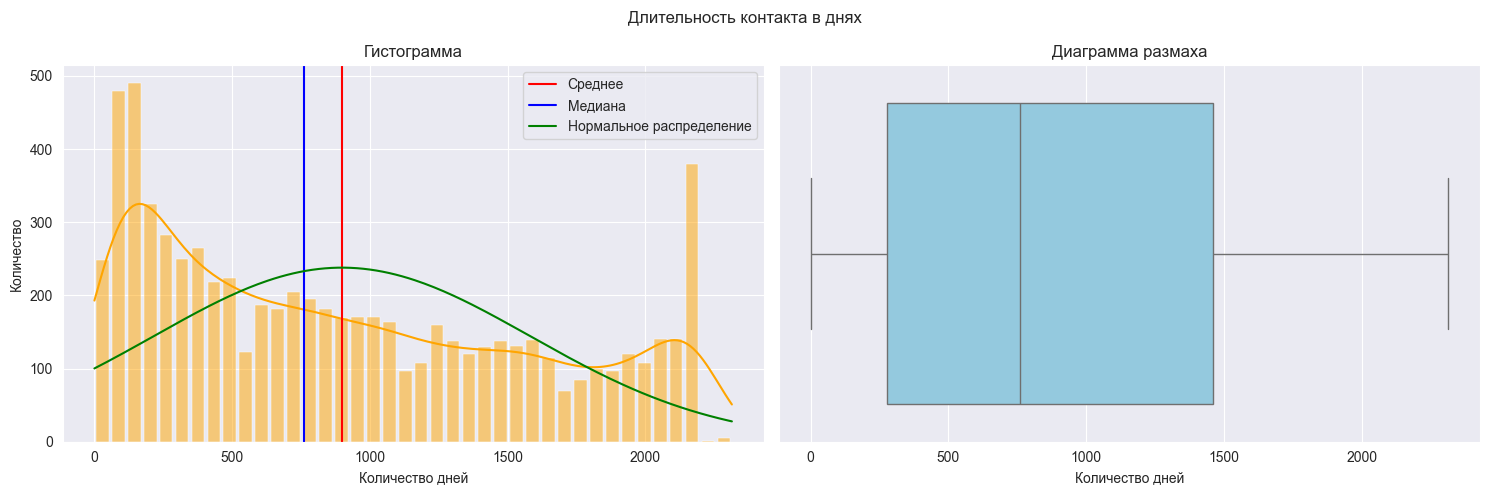

In [24]:
get_graph_plot(df_union, 'duration_contract', 'Длительность контакта в днях', 'Количество дней')

In [25]:
df_union['duration_contract'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration_contract, dtype: float64

График демонстрируют три явных пика, на начальном этапе обслуживания, и в самом конце. Средний возраст клиента около 2.5 года.

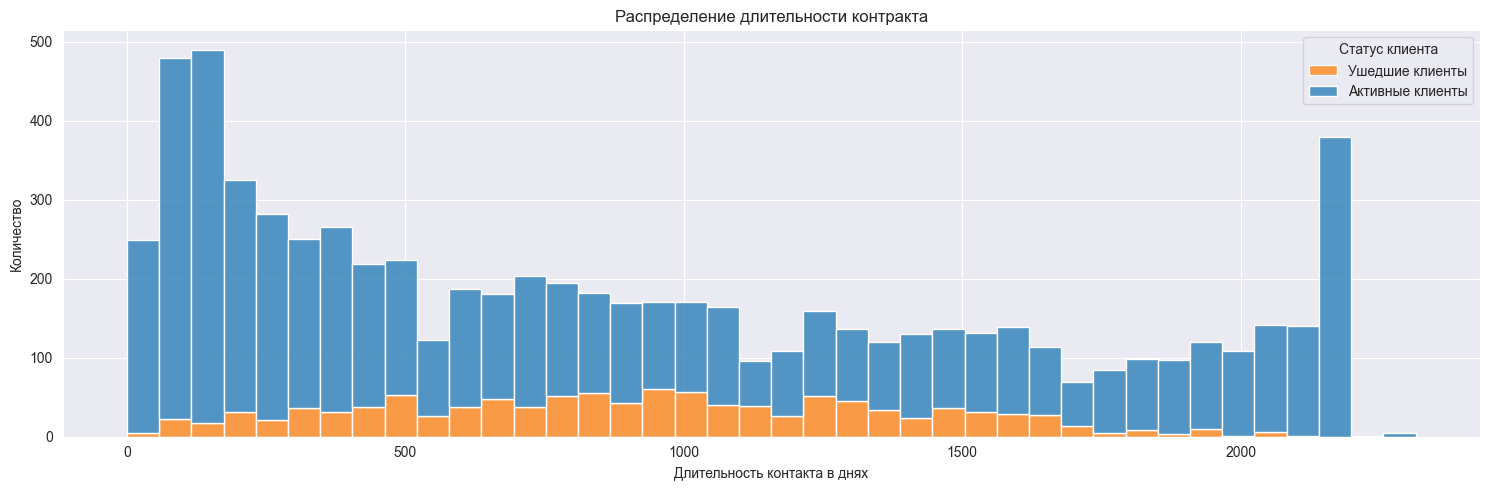

In [26]:
plt.figure(figsize=(15, 5))

sns.histplot(data=df_union, x='duration_contract', hue='activity', multiple='stack', bins=40)

plt.title('Распределение длительности контракта')
plt.xlabel('Длительность контакта в днях')
plt.ylabel('Количество')
plt.legend(title='Статус клиента', labels=['Ушедшие клиенты', 'Активные клиенты'])

plt.grid(True)
plt.tight_layout()
plt.show()

Предположение, что клиенты уходят на начальном этапе не подтвердились, рост оттока клиентов начинается с 300-го дня пользования и сходит на нет при длительности контракта от 1700 дня.

## 3.4 Признаки клиента

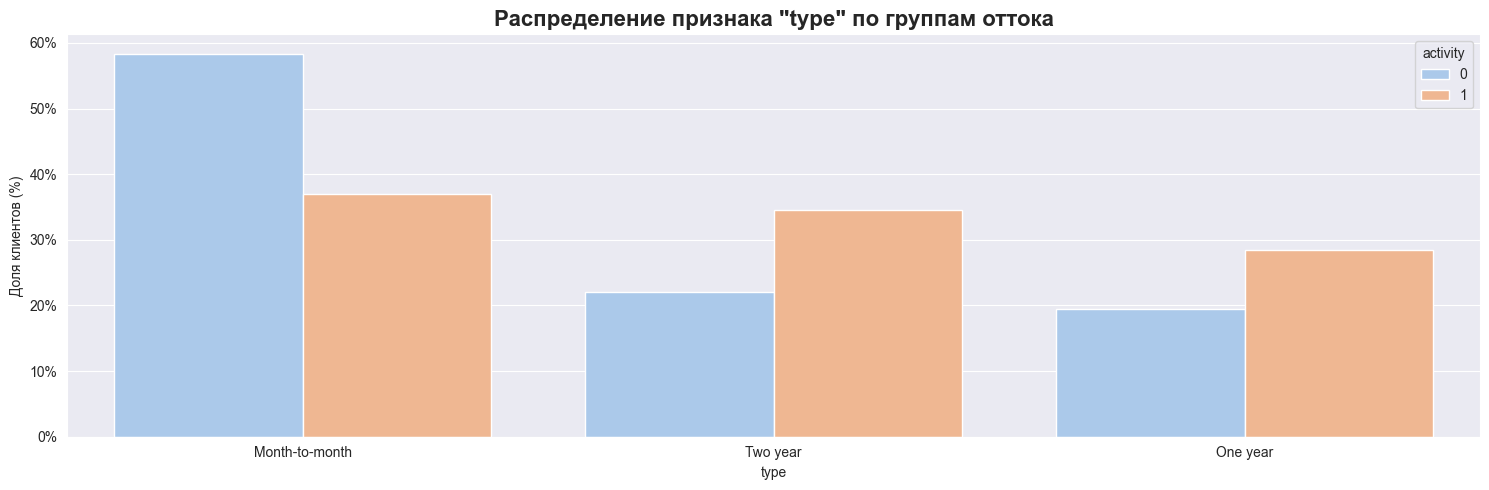

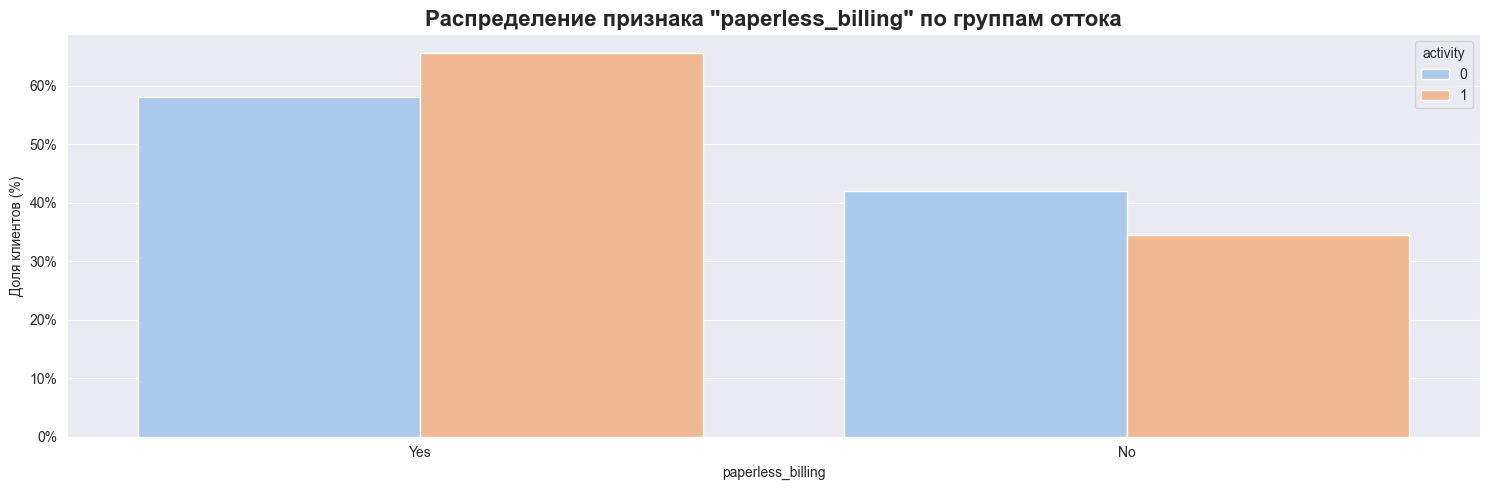

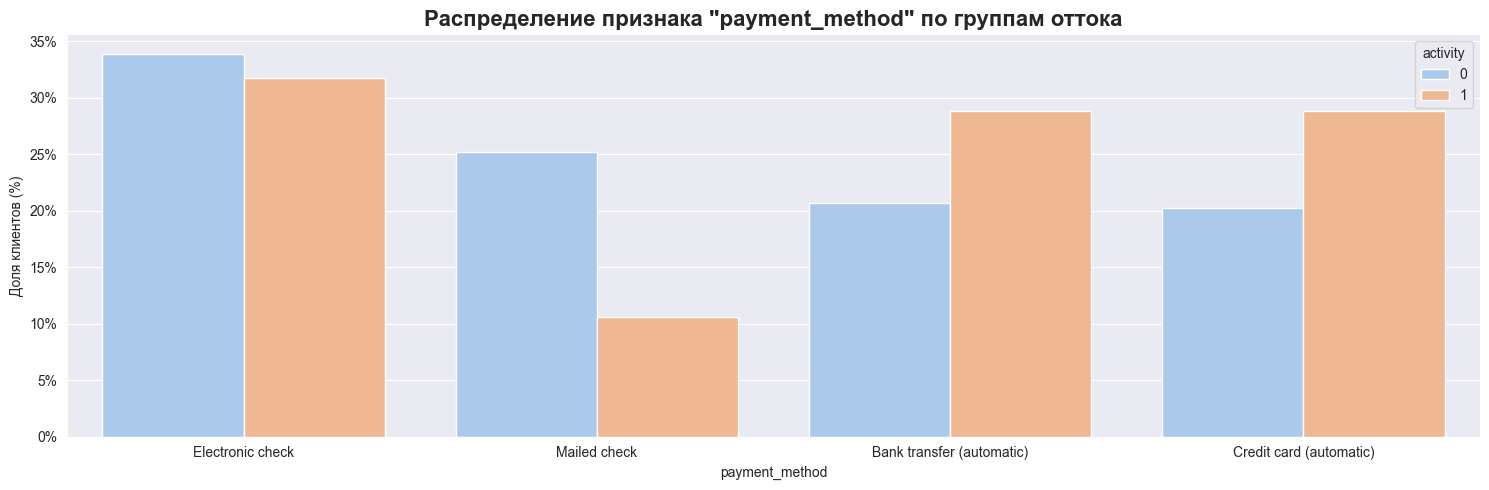

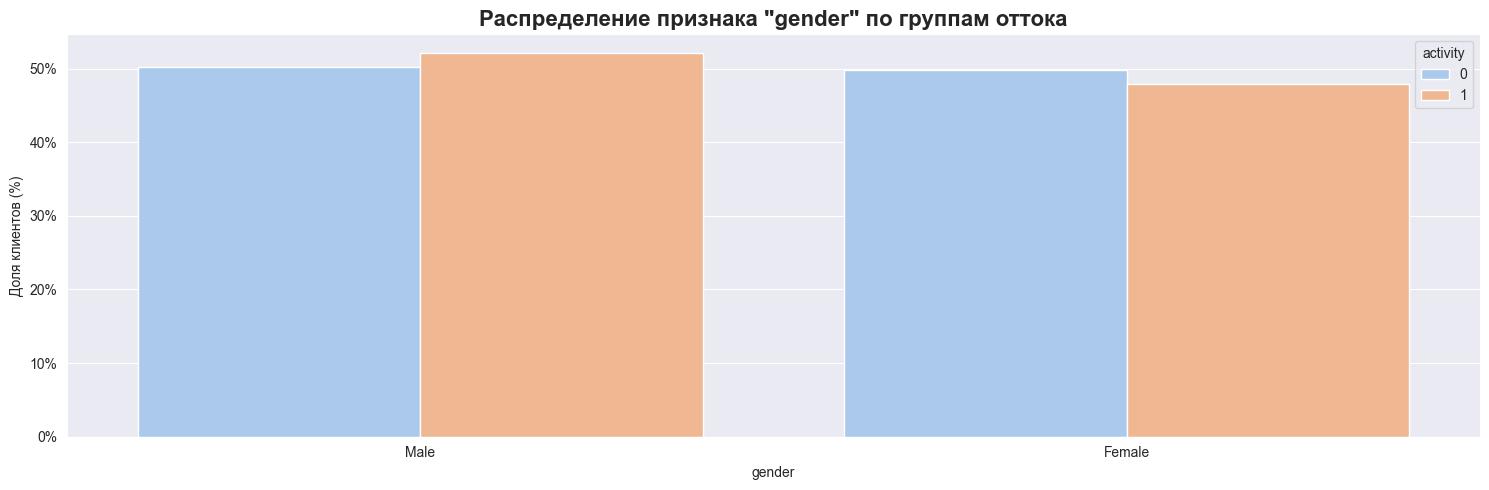

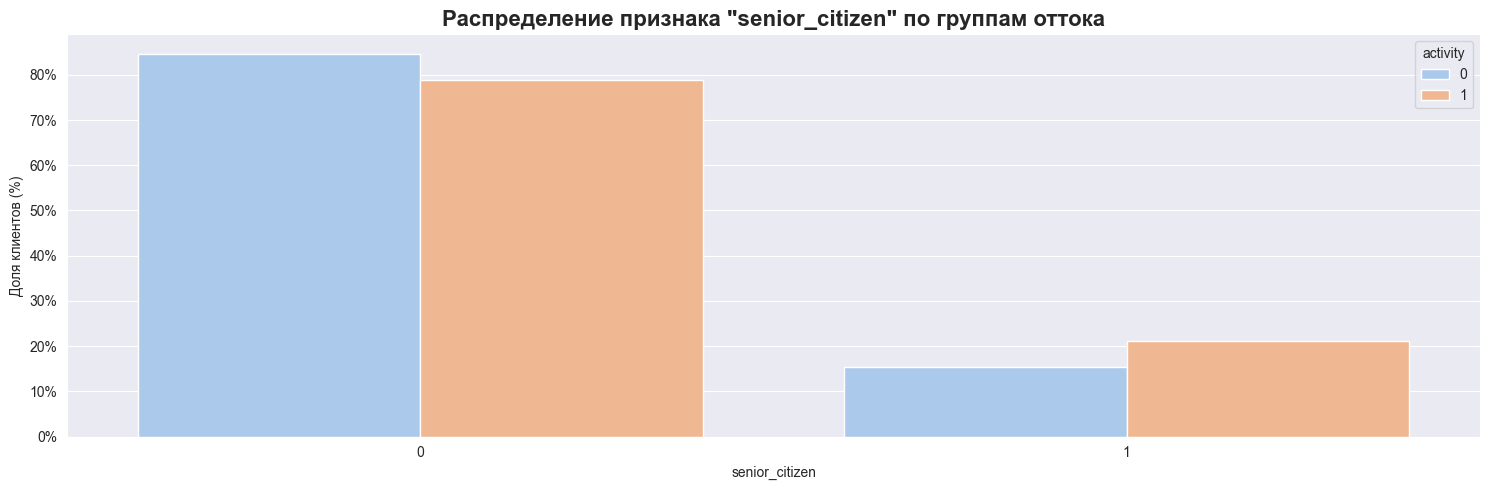

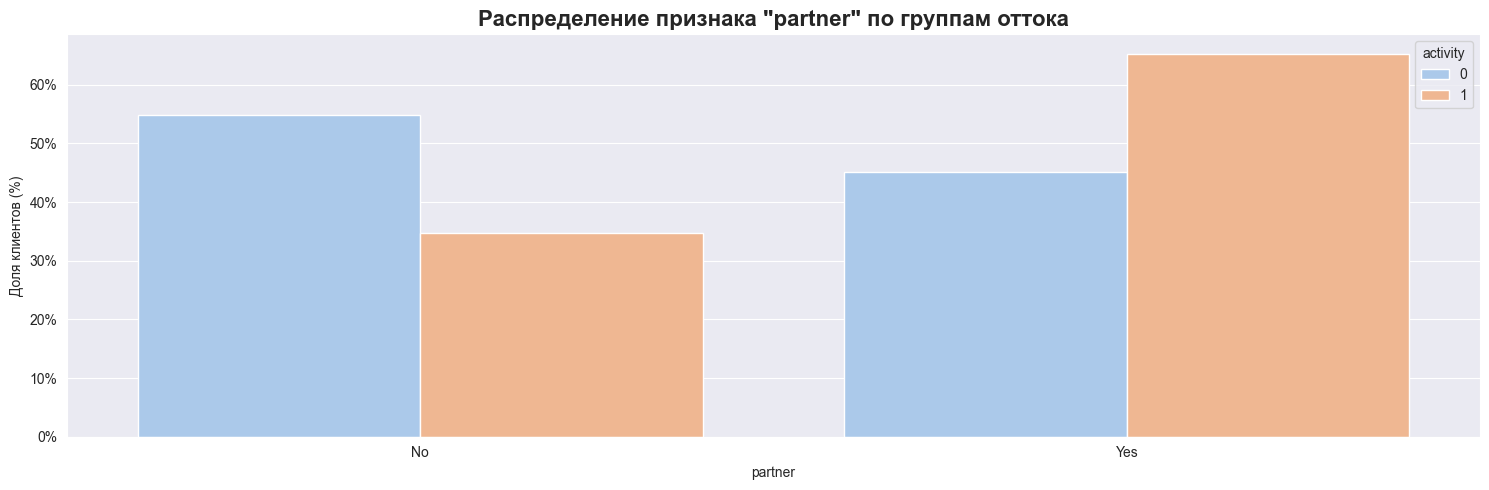

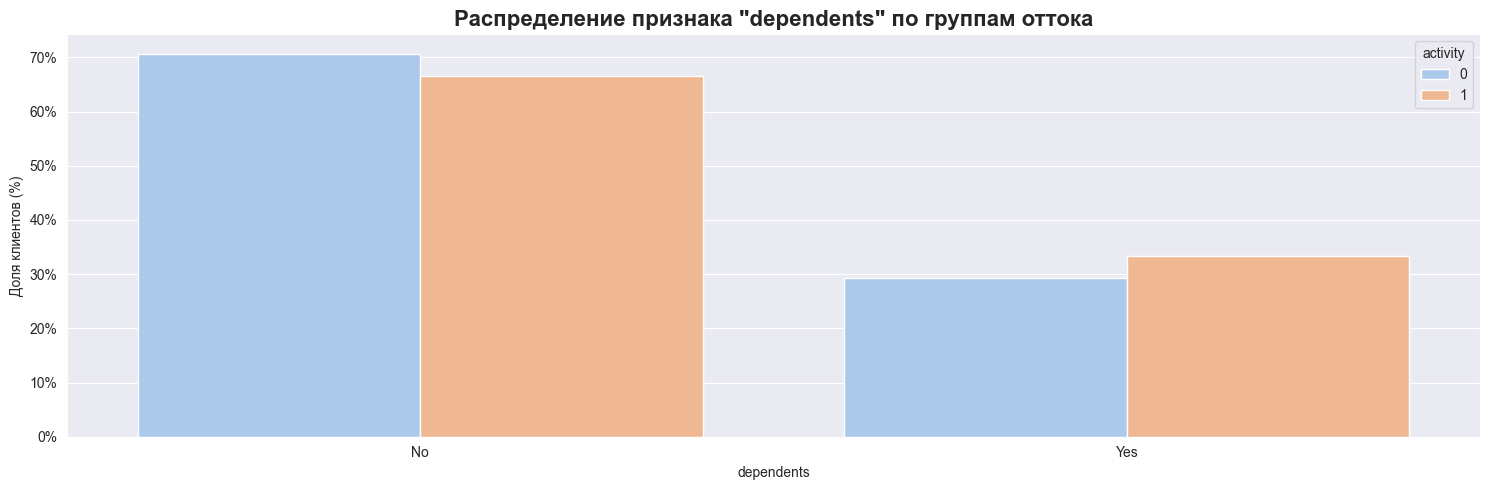

In [27]:
for column in ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents']:
    get_graph_pie(df_union, column)

- Отток клиентов чаще замечен, с помесячной моделью оплаты.
- Клиенты получающие электронные чеки, чаще разрывали договор.
- Тип платежа относительно одинаковый с отличием лишь, что меньше всего ушедших клиентов с оплатой по электронной почте.
- Разницы между мужчинами и женщинами практически нет.
- Клиенты до пенсионного возраста менее склонны к уходу.
- Семейные пары чаще расторгают договор, а количество детей не влияет на решение.

## 3.5 Признаки дополнительных услуг

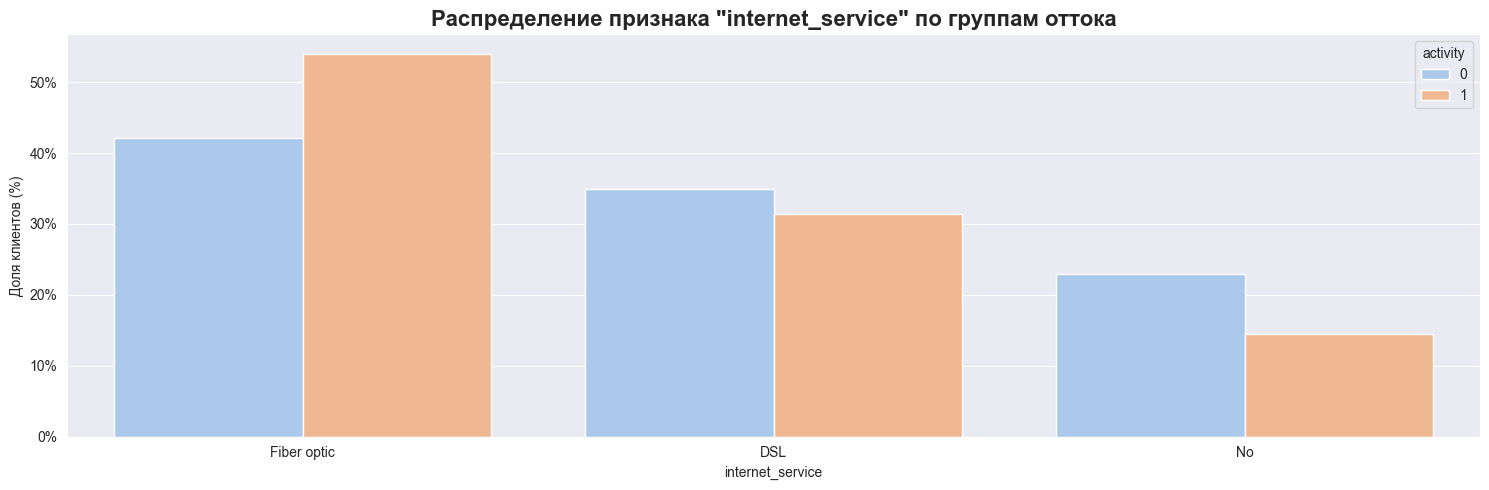

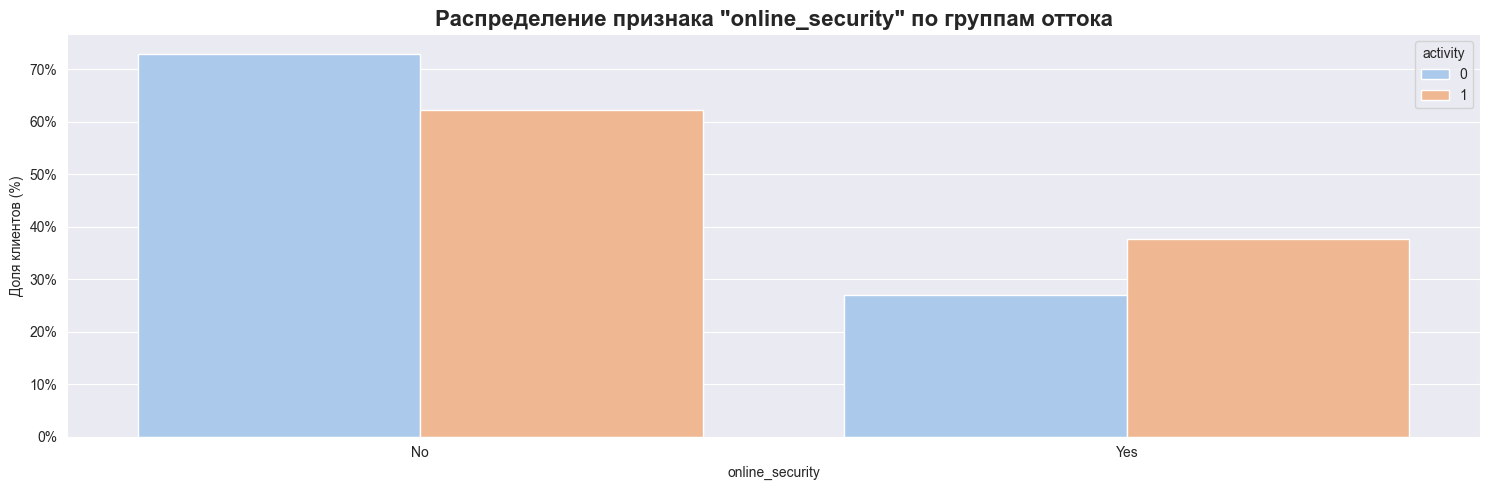

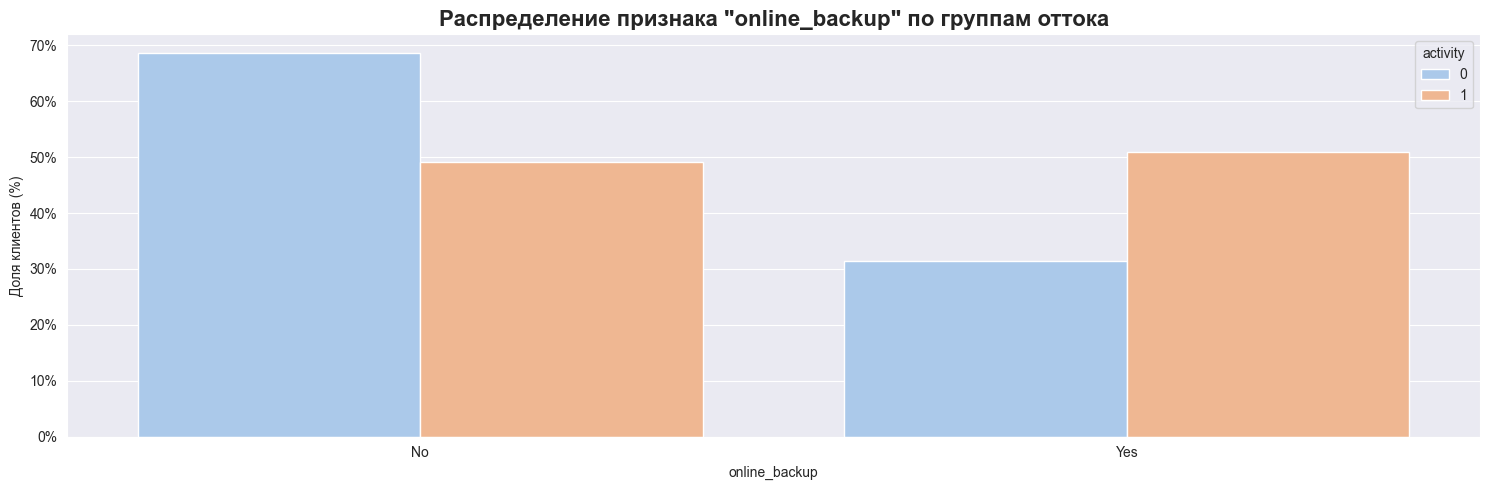

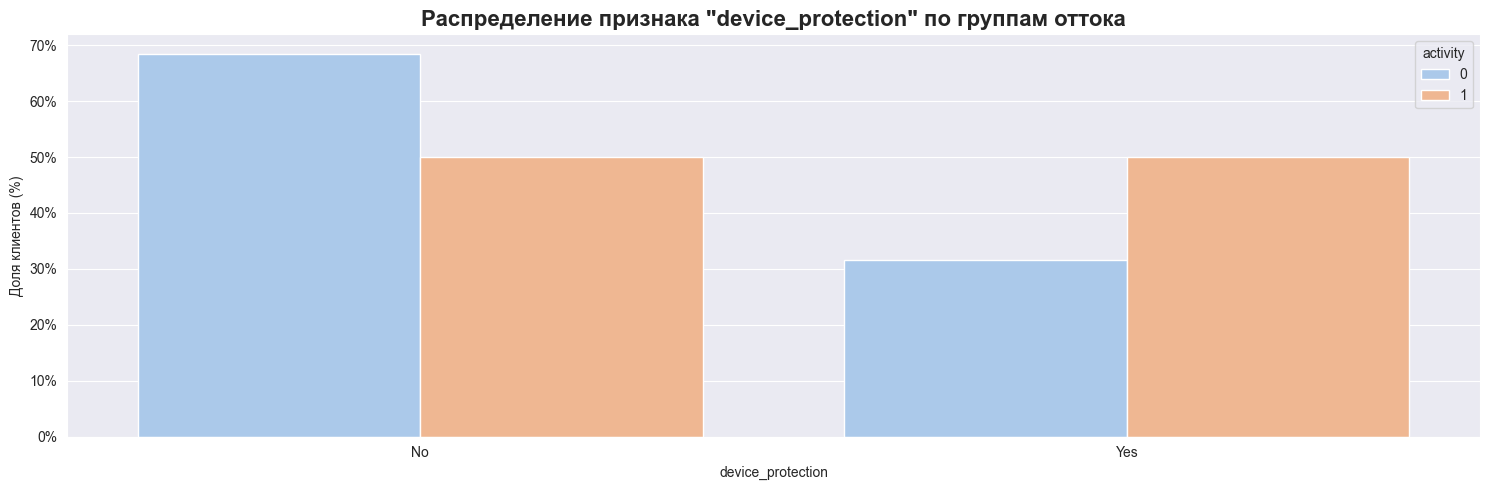

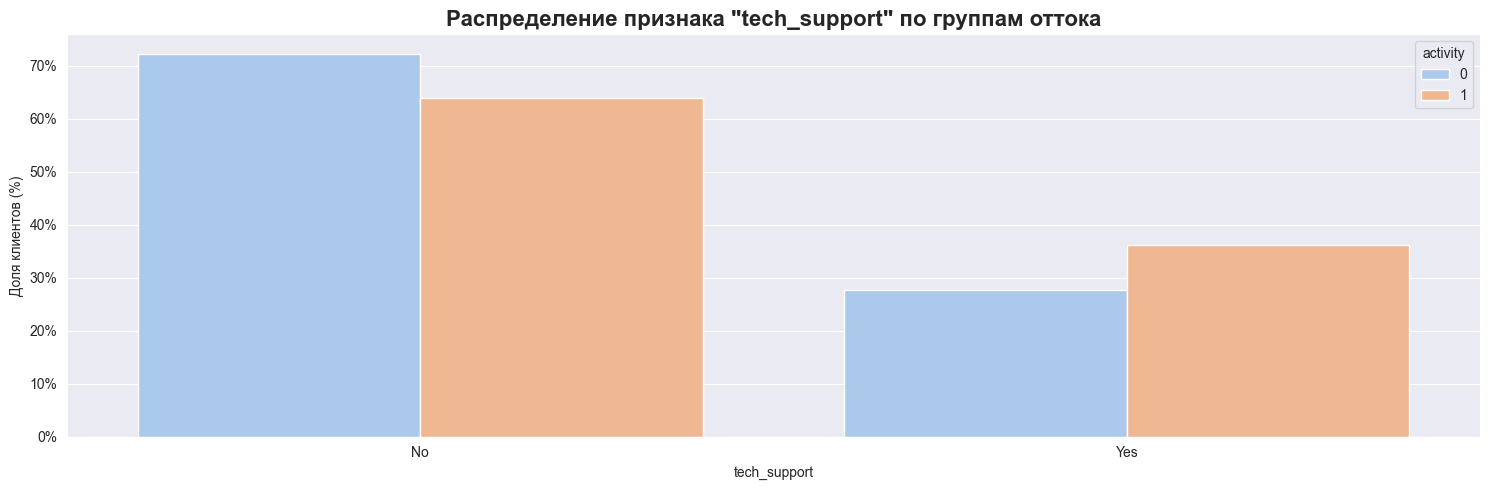

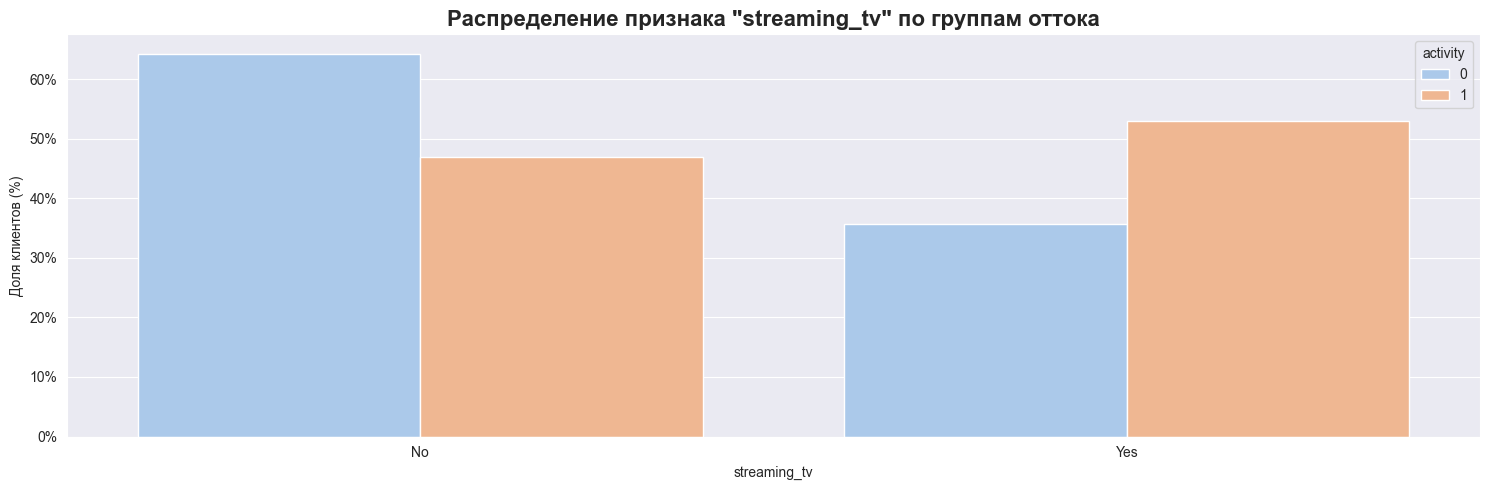

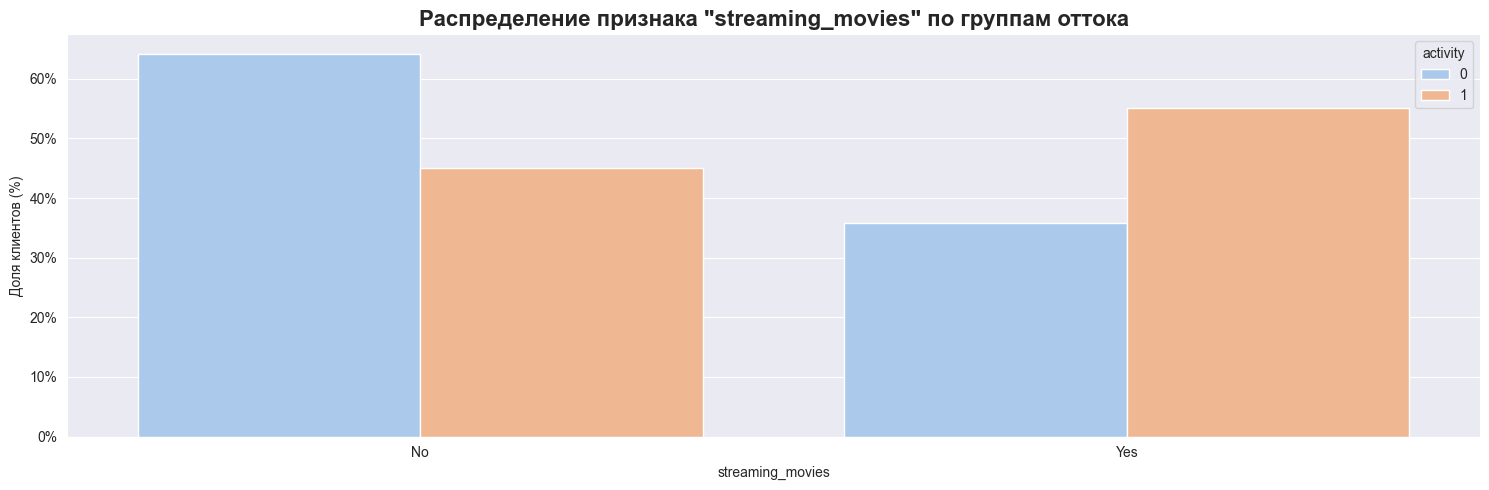

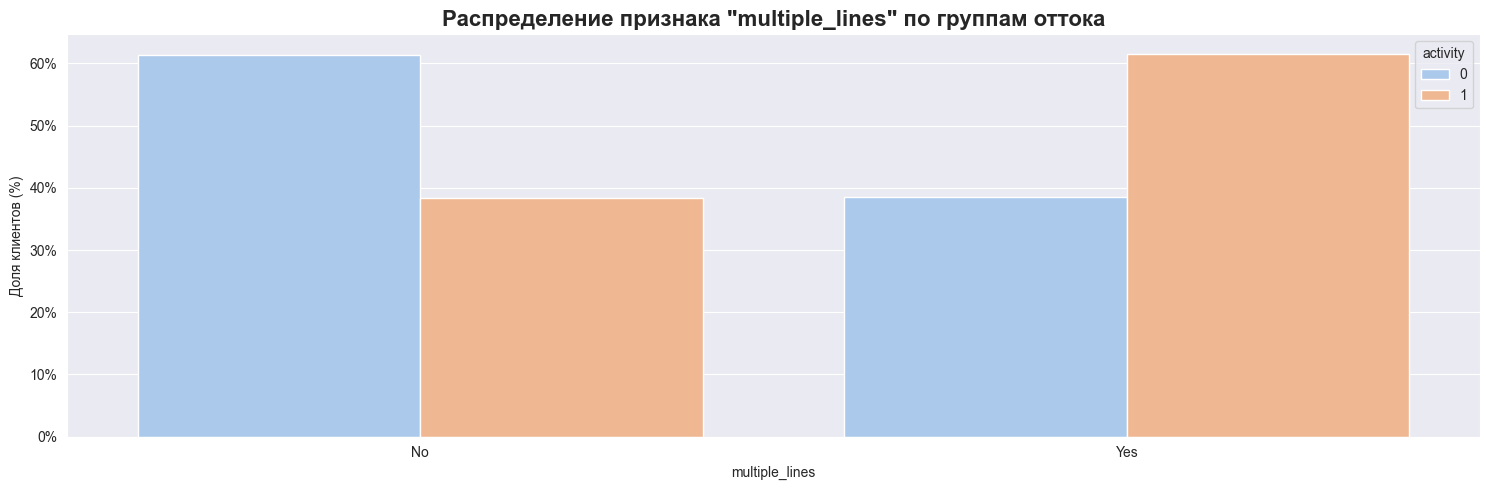

In [28]:
for column in ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    get_graph_pie(df_union, column)

Практически у всех дополнительных услуг схожая картина, при наличии дополнительных услуг, клиенты чаще расторгают договор.

## Промежуточный вывод

По исследованным данным, уже можно составить ориентировочный профиль клиента в зоне риска.

Клиент состоящий в браке до пенсионного возраста, чей договор не длится дольше 1700 дней и получающий электронный чек имеющий подключение по `Fiber Optic` и пользующийся любой из предложенных дополнительных услуг особенно если среди них имеются:

- Антивирус
- Облачное хранилище
- Защита устройства
- Стриминг видео или каталог фильмов

Из представленных выше графиков можно выделить, что в подавляющим случае дополнительными услугами пользуются около 30% всех пользователей.

# 4. Корреляционный анализ

In [29]:
interval_column = ['monthly_charges', 'total_charges', 'duration_contract']
drops_column = ['customer_id', 'begin_date', 'end_date']

In [30]:
activity = df_union['activity']
df_union = df_union.drop(['activity'], axis=1)
df_union.insert(0, 'activity', activity)

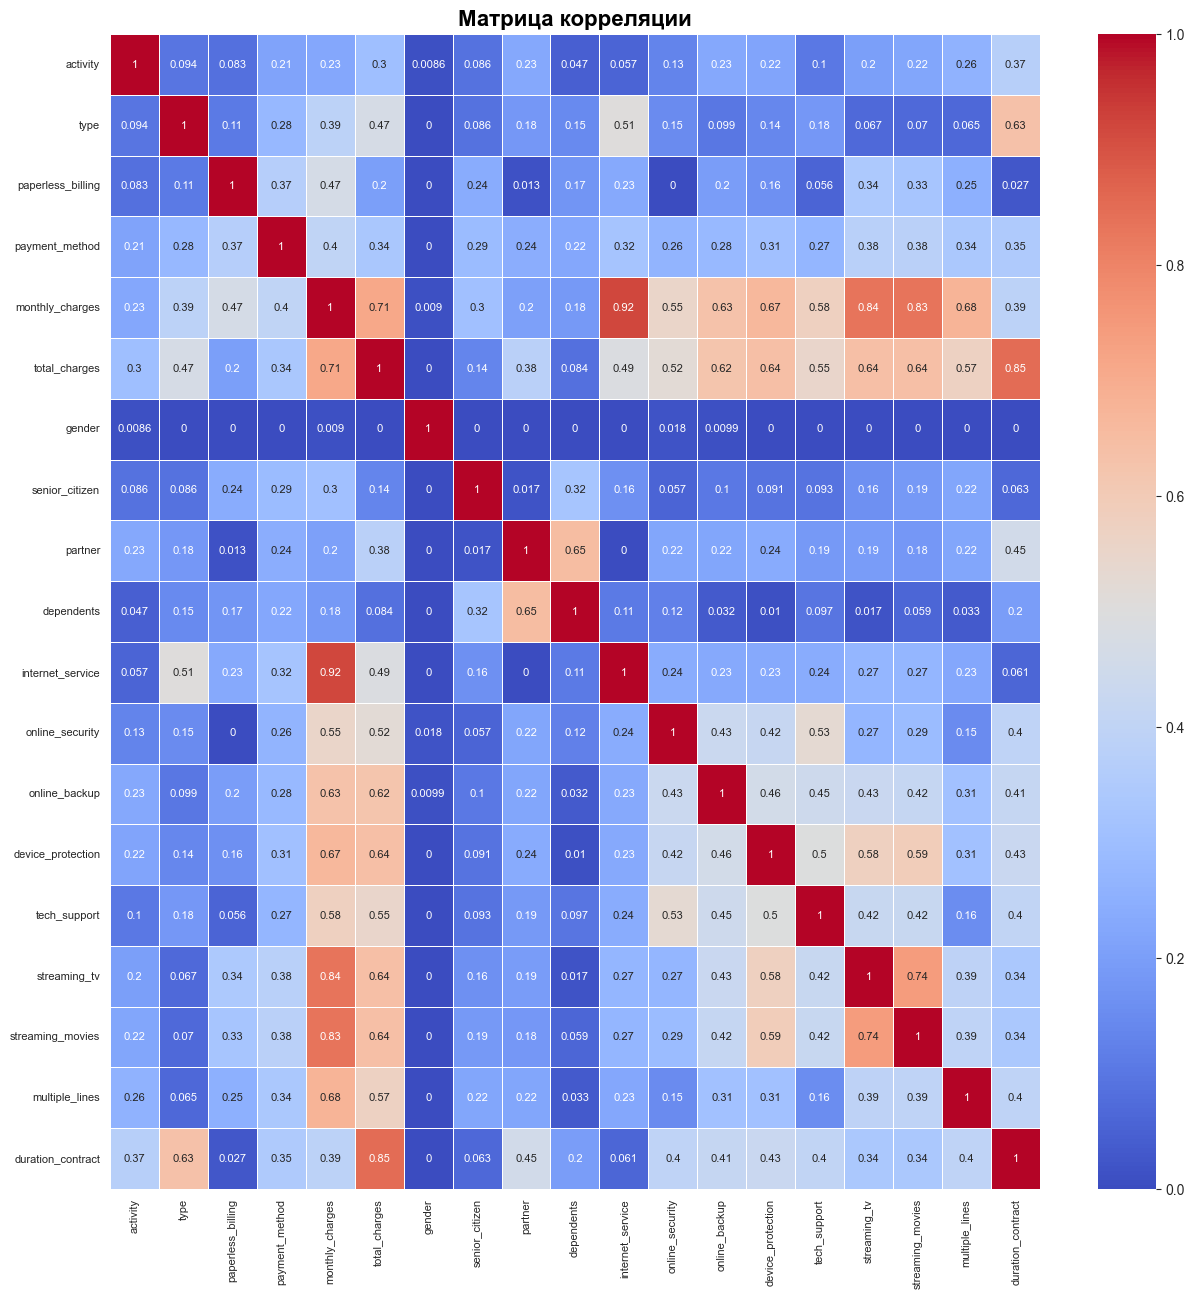

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(df_union.drop(drops_column, axis=1).phik_matrix(interval_cols=interval_column), annot=True, linewidths=0.5, annot_kws={"size": 8}, cmap='coolwarm')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Матрица корреляции', fontsize=16, fontweight="bold", color='black');

Перед окончательным анализом, первым бросается в глаза высокая мультиколленеарность у признаков услуг. Чтобы её устранить добавим новый признак `service_count` где подсчитаем количество услуг.

In [32]:
services = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

df_union['service_count'] = (df_union[services].apply(lambda row: sum(x == 'Yes' for x in row), axis=1))

In [33]:
drops_column = ['customer_id', 
                'begin_date', 
                'end_date', 
                'internet_service', 
                'online_security', 
                'online_backup', 
                'device_protection', 
                'tech_support', 
                'streaming_tv', 
                'streaming_movies']

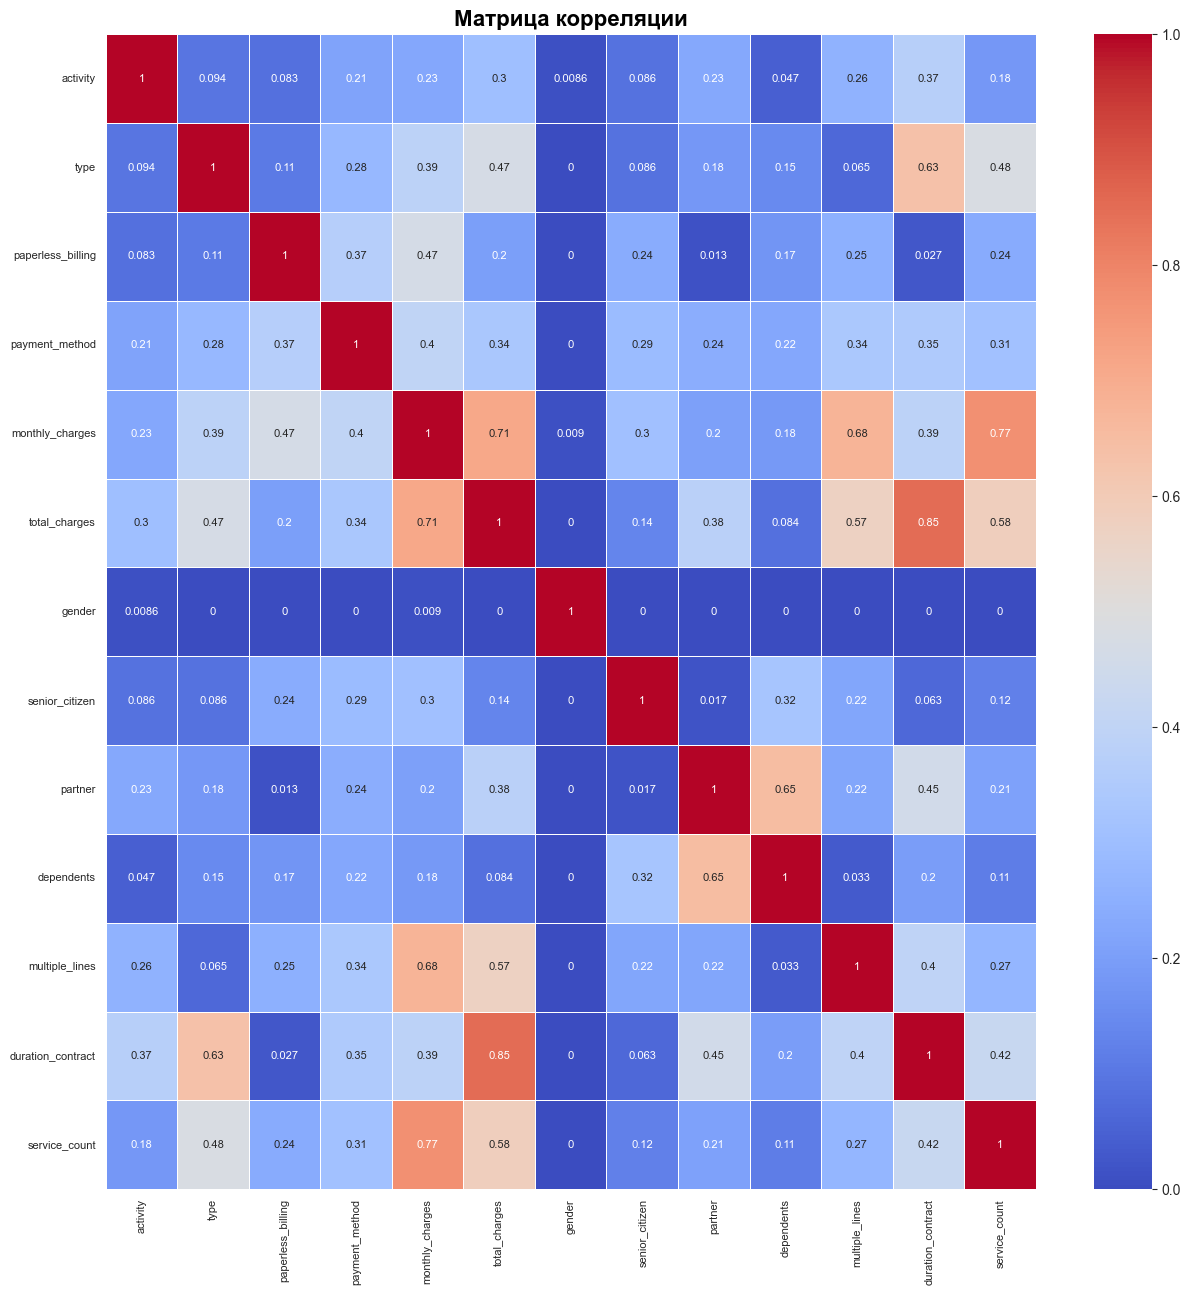

In [34]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_union.drop(drops_column, axis=1).phik_matrix(interval_cols=interval_column), 
            annot=True, linewidths=0.5, annot_kws={"size": 8}, cmap='coolwarm')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Матрица корреляции', fontsize=16, fontweight="bold", color='black');

# 5. Модели машинного обучения

In [35]:
df_models = df_union.drop(['customer_id',
                           'begin_date',
                           'end_date',
                           'internet_service',
                           'online_security',
                           'online_backup',
                           'device_protection',
                           'tech_support',
                           'streaming_tv',
                           'streaming_movies'], axis=1)

In [36]:
RS = 300625
TS = 0.25

number_columns = ['monthly_charges', 
                  'total_charges', 
                  'duration_contract', 
                  'service_count']

category_column = ['type', 
                   'paperless_billing', 
                   'payment_method', 
                   'gender', 
                   'senior_citizen', 
                   'partner', 
                   'dependents', 
                   'multiple_lines']

X = df_models.drop('activity', axis=1)
Y = df_models['activity']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TS, random_state=RS, stratify=Y, shuffle=True)

In [37]:
ohe_column = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('ohe', ohe_column, category_column),
    ('num', MinMaxScaler(), number_columns)
])

pipline = Pipeline([
    ('preprocessor_pipline', preprocessor),
    ('models', LogisticRegression(random_state=RS))
])

In [38]:
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RS)],
        'models__n_estimators': [75, 100, 150],
        'models__max_features': ['auto', 'sqrt', 'log2']
    },
    {
        'models': [CatBoostClassifier(random_state=RS)],
        'models__iterations': range(100, 1000, 100),
        'models__learning_rate': [0.01, 0.05, 0.1, 0.3],
        'models__depth': range(2, 8, 1)
    }
]

In [39]:
grid_search = GridSearchCV(
    pipline,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    cv=3
)

In [40]:
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 3 folds for each of 225 candidates, totalling 675 fits


D:\LPD\DataModelLab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\LPD\DataModelLab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\LPD\DataModelLab\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\LPD\DataModelLab\.venv\Lib\site-packages\sklearn\pipeline.py", line 661, in fit
    self._final_estimator.

0:	learn: 0.5343626	total: 134ms	remaining: 2m
1:	learn: 0.4656576	total: 135ms	remaining: 1m
2:	learn: 0.4169641	total: 136ms	remaining: 40.7s
3:	learn: 0.4005370	total: 137ms	remaining: 30.7s
4:	learn: 0.3867549	total: 138ms	remaining: 24.7s
5:	learn: 0.3748323	total: 139ms	remaining: 20.7s
6:	learn: 0.3698719	total: 140ms	remaining: 17.8s
7:	learn: 0.3639366	total: 140ms	remaining: 15.7s
8:	learn: 0.3597300	total: 141ms	remaining: 14s
9:	learn: 0.3549474	total: 142ms	remaining: 12.6s
10:	learn: 0.3515875	total: 143ms	remaining: 11.5s
11:	learn: 0.3473052	total: 144ms	remaining: 10.6s
12:	learn: 0.3452884	total: 144ms	remaining: 9.85s
13:	learn: 0.3413915	total: 145ms	remaining: 9.2s
14:	learn: 0.3399346	total: 146ms	remaining: 8.62s
15:	learn: 0.3390675	total: 147ms	remaining: 8.12s
16:	learn: 0.3379251	total: 148ms	remaining: 7.67s
17:	learn: 0.3366623	total: 149ms	remaining: 7.29s
18:	learn: 0.3355748	total: 149ms	remaining: 6.93s
19:	learn: 0.3351179	total: 150ms	remaining: 6.61s

In [41]:
best_model

,steps,"[('preprocessor_pipline', ...), ('models', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
best_params

{'models': <catboost.core.CatBoostClassifier at 0x1f31cb46550>,
 'models__depth': 2,
 'models__iterations': 900,
 'models__learning_rate': 0.3}

In [43]:
y_predict = best_model.predict_proba(x_test)[:, 1]



In [44]:
print(f'Метрика ROC AUC лучшей модели на тренировочной выборке: {best_score:.2f}')
print(f'Метрика ROC AUC лучшей модели на тестовой выборке: {round(roc_auc_score(y_test, y_predict), 2)}')

Метрика ROC AUC лучшей модели на тренировочной выборке: 0.92
Метрика ROC AUC лучшей модели на тестовой выборке: 0.93


# 6. Оценка важности признаков

In [45]:
X_processed = best_model.named_steps['preprocessor_pipline'].transform(x_train)
feature_names = best_model['preprocessor_pipline'].get_feature_names_out()
data = pd.DataFrame(X_processed, columns=feature_names)

In [46]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   activity           7043 non-null   int64  
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  multiple_lines     7043 non-null   object 
 11  duration_contract  7043 non-null   int64  
 12  service_count      7043 non-null   int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 715.4+ KB


 96%|=================== | 5080/5282 [00:18<00:00]       

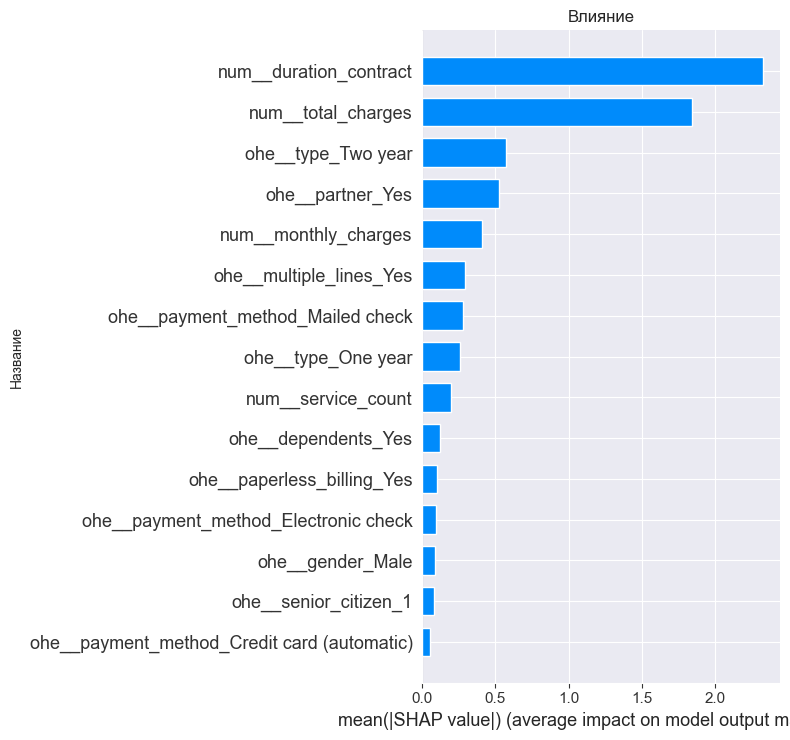

In [47]:
explainer = shap.TreeExplainer(best_model.named_steps['models'], data)
shap_values = explainer.shap_values(data)

plt.ylabel("Название")
plt.title("Влияние")

shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type="bar", max_display=15)

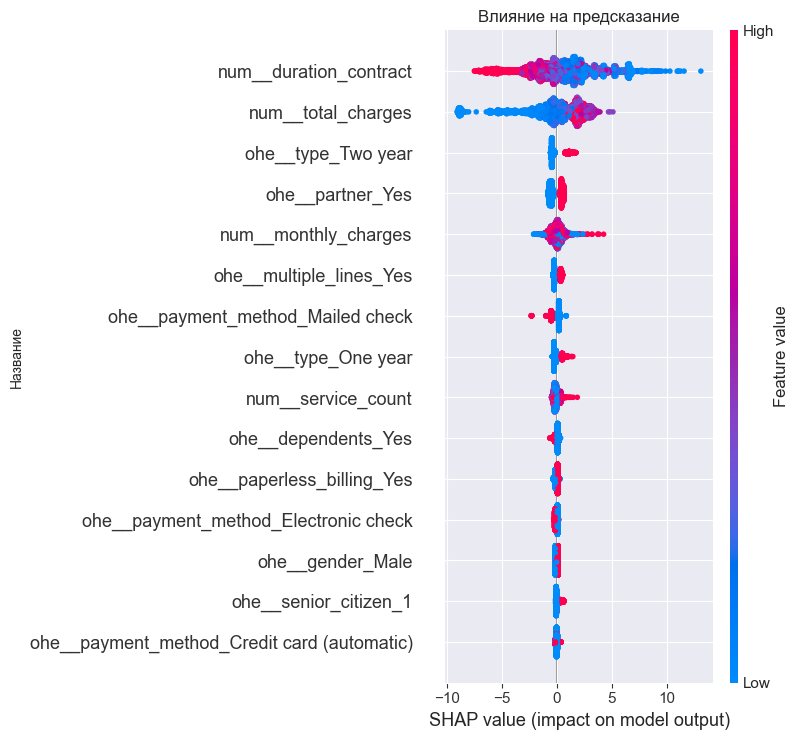

In [48]:
plt.ylabel("Название")
plt.title("Влияние на предсказание")

shap.summary_plot(shap_values, X_processed, feature_names=feature_names, max_display=15)

## Промежуточный вывод

Самыми значимыми признаками для модели из топ 15 оказались `duration_contract` и `total_charges`, так же можно выделить признаки оказавшие меньшее влияние, но по-прежнему важные для модели `type`, `partner`, `service_count`, `monthly_charges`, `multiple_lines`. А вот признаки `paperless_billing`, `senior_citizen` практически не оказали влияние на предсказание.

# 7. Оценка качества предсказаний

In [49]:
y_pred = (y_predict >= 0.5).astype(int)

cm = confusion_matrix(y_test, np.round(y_pred))

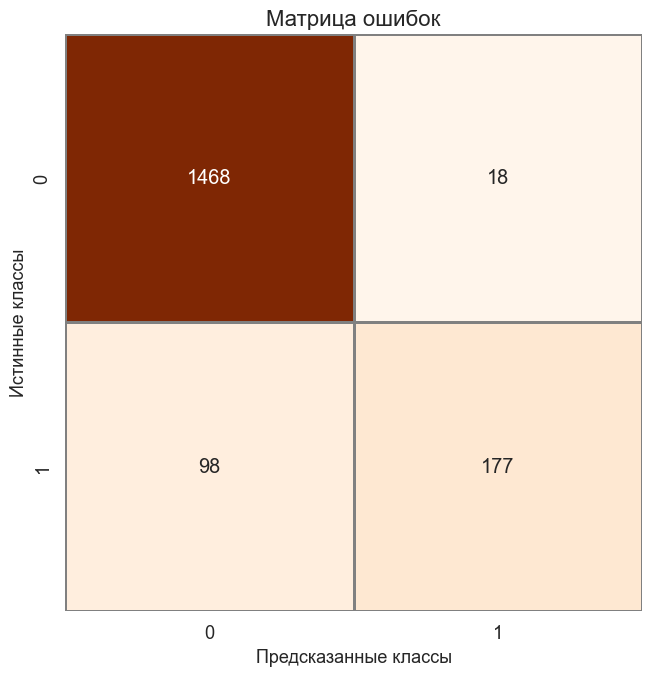

In [50]:
plt.figure(figsize=(15, 7))
sns.set(style="white", font_scale=1.2)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False, square=True, linewidths=1, linecolor='gray')

plt.title("Матрица ошибок", fontsize=16)
plt.xlabel("Предсказанные классы", fontsize=13)
plt.ylabel("Истинные классы", fontsize=13)

plt.tight_layout()
plt.show()

Модель предсказала 1473 раза правильно, в ситуации, где клиент не разрывает договор и 194 раза предсказано верно, разрыв договора.

# Общий вывод

В рамках проекта, была построена модель, для предсказания оттока клиентов оператора связи ТелеДом. Проведена полная обработка и объединение данных из разных источников, реализован отбор признаков и обучение `RandomForestClassifier` и `CatBoostClassifier` с подбором гиперпараметров через `GridSearchCV`.

Лучшие результаты показала модель `CatBoostClassifier` результат метрики `ROC AUC` на `0.915` на тренировочной выборке и `0.939` на тестовой, что говорит о хорошем качестве классификации даже при несбалансированных классах.

С помощью метода SHAP определены ключевые признаки, влияющие на предсказание:

- Самыми значимыми оказались:
    - `duration_contract` (длительность договора),
    - `total_charges` (суммарные затраты клиента).
- Также существенное влияние оказали: `type`, `partner`, `service_count`, `monthly_charges`, `multiple_lines`.
- Почти не влияли на отток: `paperless_billing`, `senior_citizen`.

Матрица ошибок показывает, что модель хорошо определяет клиентов не склонных к закрытию договора, хуже модель справляется с определением клиентов планирующим уход. В зависимости от бизнес-задачи можно скорректировать порог классификации, для выявления целевой группы.